# Entregable 3 - Modelo de predicción de hábitos de consumo

El objetivo de este entregable fue generar un modelo de estimación de hábitos de consumo para suministros que carezcan de medidores inteligentes. Para ello se utilizó un modelo de predicción de series temporales con componente de estacionalidad, incorporando información de variables exógenas (SARIMAX).

## Carga de librerías y archivos

In [293]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [294]:
#from google.colab import drive
#drive.mount('/content/drive')
#file_path = '/content/drive/My Drive/00 - Diplodatos/Diplodatos desde 2704/modelo_epec.csv'
#final_df = pd.read_csv(file_path, sep=';')

In [295]:
# Cargar previamente modelo_epec.csv en la sesión de Google Colab
final_df = pd.read_csv('modelo_epec.csv', sep=';')

## Preparación de los datos

A modo de síntesis de lo trabajado en los entregables 1 y 2, se llegó a la creación del dataset modelo_epec.csv con datos de consumo y otras variables de interés (grupos tarifarios, información climática, información geoespacial, información temporal -día de la semana y día hábil/no hábil-, entre otras).

En base a lo analizado en los entregables pasados, se determinó que las variables que aportaban al comportamiento del consumo eran pricipalmente las relacionadas a los grupos tarifarios y a la temperatura. En base a esto, estas variables fueron las utilizadas como eje en este entregable.

In [296]:
with pd.option_context('display.max_columns', None):
    print(final_df.head())

   DEVICE          TV  consumo  consumo_pico  consumo_valle  consumo_resto  \
0     0.0  2023-01-02    4.508         1.064          1.521          1.923   
1     0.0  2023-01-03    3.803         0.906          1.000          1.897   
2     0.0  2023-01-04    3.837         0.922          0.908          2.007   
3     0.0  2023-01-05    3.648         0.852          0.957          1.839   
4     0.0  2023-01-06    4.218         0.938          1.038          2.242   

   Maxima_Demanda  Dia_Consumo  Semana_Consumo  Mes_Consumo  is_business_day  \
0           0.484          0.0               1          1.0              1.0   
1           0.516          1.0               1          1.0              1.0   
2           0.592          2.0               1          1.0              1.0   
3           0.592          3.0               1          1.0              1.0   
4           0.592          4.0               1          1.0              1.0   

   precipitaciones  temperatura_min  temperatura_m

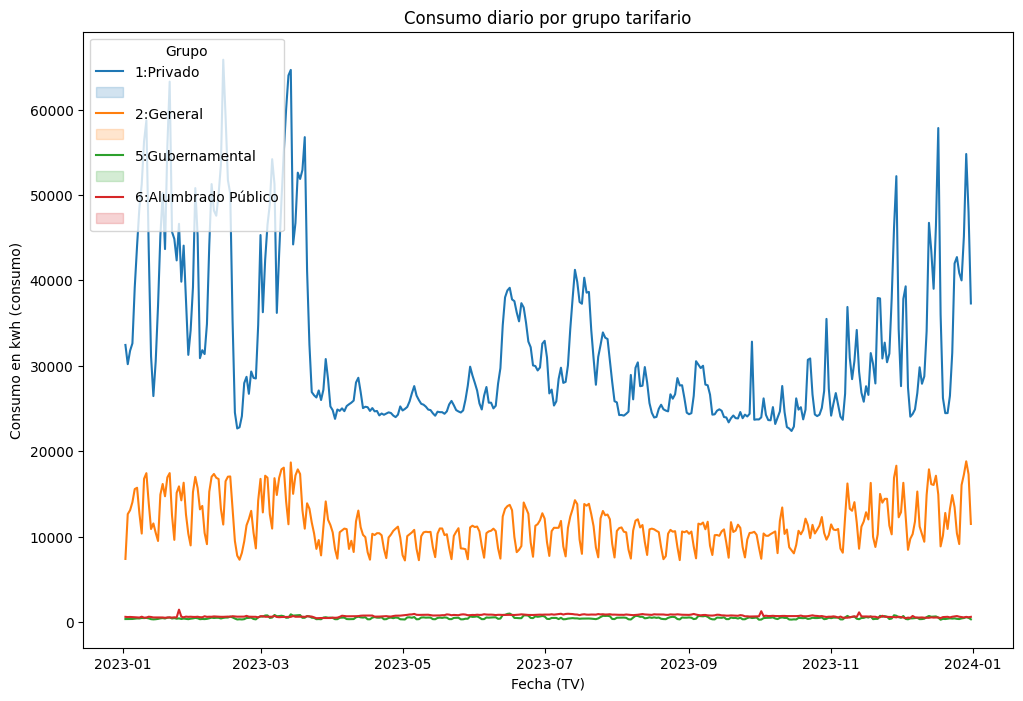

In [297]:
# Consumo diario por grupo tarifario
consumo_grupo_tarifario = final_df.groupby(['TV','grupo_tarifario','temperatura_max','temperatura_min','temperatura_avg','precipitaciones','Dia_Consumo','Mes_Consumo','is_business_day'], as_index=False)[['consumo','Maxima_Demanda']].sum()
consumo_grupo_tarifario['TV'] = pd.to_datetime(consumo_grupo_tarifario['TV'], format='%Y-%m-%d')

fig, ax = plt.subplots(figsize=(12, 8))

# Target: Consumo
sns.lineplot(x="TV", y="consumo",
             hue="grupo_tarifario",
             data=consumo_grupo_tarifario, palette=sns.color_palette())

# Referencias
ax.set(xlabel='Fecha (TV)',
       ylabel='Consumo en kwh (consumo)',
       title='Consumo diario por grupo tarifario')
plt.legend(title='Grupo', loc='upper left', labels=['1:Privado', '','2:General','', '5:Gubernamental', '','6:Alumbrado Público',''])
plt.show()

En relación a los grupos tarifarios, se decidió trabajar sólo con el grupo tarifario 1 (privado), el cual abarca el 89% de los medidores con los que el dataset contaba. Los grupos 5 (gubernamental) y 6 (alumbrado público) mostraron un consumo constante en relación a los grupos 1 y 2, por lo que fueron descartados para la preparación del modelo porque su predicción carece de interés. Con respecto al grupo 2 (general), se observó que dentro de este grupo el consumo por medidor presentaba alta avriabilidad, por lo que por cuestiones de simplificación también fue excluido del análisis.


In [298]:
total_unique_devices = final_df['DEVICE'].nunique()

grupo_1_devices = final_df[final_df['grupo_tarifario'] == 1]
grupo_2_devices = final_df[final_df['grupo_tarifario'] == 2]
grupo_5_devices = final_df[final_df['grupo_tarifario'] == 5]
grupo_6_devices = final_df[final_df['grupo_tarifario'] == 6]

unique_devices_grupo_1 = grupo_1_devices['DEVICE'].nunique()
unique_devices_grupo_2 = grupo_2_devices['DEVICE'].nunique()
unique_devices_grupo_5 = grupo_5_devices['DEVICE'].nunique()
unique_devices_grupo_6 = grupo_6_devices['DEVICE'].nunique()

print(f"Total number of unique devices: {total_unique_devices}")
print(f"Número de devices en Grupo Tarifario 1: {unique_devices_grupo_1}")
print(f"Número de devices en Grupo Tarifario 1: {unique_devices_grupo_2}")
print(f"Número de devices en Grupo Tarifario 1: {unique_devices_grupo_5}")
print(f"Número de devices en Grupo Tarifario 1: {unique_devices_grupo_6}")

Total number of unique devices: 4751
Número de devices en Grupo Tarifario 1: 4216
Número de devices en Grupo Tarifario 1: 496
Número de devices en Grupo Tarifario 1: 19
Número de devices en Grupo Tarifario 1: 20


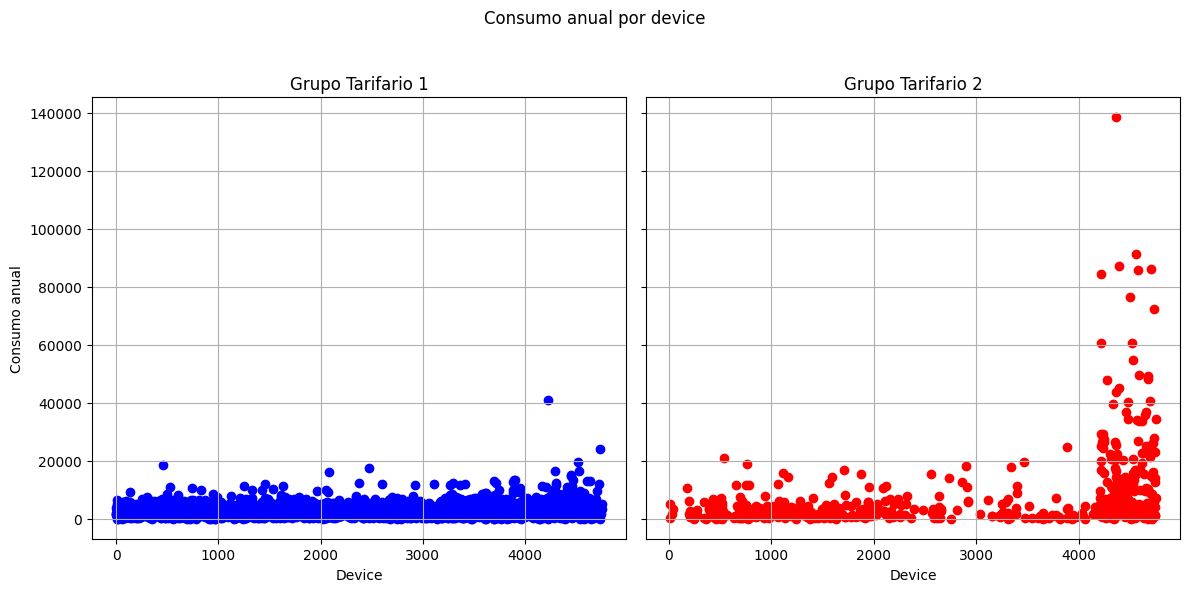

In [299]:
# Consumo anual por device en grupos tarifarios 1 y 2
group_1 = final_df[final_df['grupo_tarifario'] == 1].groupby('DEVICE')['consumo'].sum().reset_index()
group_2 = final_df[final_df['grupo_tarifario'] == 2].groupby('DEVICE')['consumo'].sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scatter plot para grupo 1
axes[0].scatter(group_1['DEVICE'], group_1['consumo'], color='blue')
axes[0].set_title('Grupo Tarifario 1')
axes[0].set_xlabel('Device')
axes[0].set_ylabel('Consumo anual')
axes[0].grid(True)

# Scatter plot para grupo 1
axes[1].scatter(group_2['DEVICE'], group_2['consumo'], color='red')
axes[1].set_title('Grupo Tarifario 2')
axes[1].set_xlabel('Device')
axes[1].grid(True)

plt.suptitle('Consumo anual por device')
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


In [300]:
# Se genera dataframe de Grupo Tarifario 1 y se eliminan las columnas que no serán analizadas en este trabajo
grupo_1_df = final_df[final_df['grupo_tarifario'] == 1].copy()

columns_to_drop = [
    'Maxima_Demanda', 'Dia_Consumo', 'Semana_Consumo', 'Mes_Consumo',
    'is_business_day', 'precipitaciones', 'distribuidor', 'subestacion',
    'distrito', 'grupo_tarifario', 'tarifa', 'emae'
]

grupo_1_df = grupo_1_df.drop(columns=columns_to_drop)

In [301]:
grupo_1_df.head()

,DEVICE,TV,consumo,consumo_pico,consumo_valle,consumo_resto,temperatura_min,temperatura_max,temperatura_avg
0,0.0,2023-01-02,4.508,1.064,1.521,1.923,15.0,32.1,24.5
1,0.0,2023-01-03,3.803,0.906,1.000,1.897,18.0,31.5,24.5
2,0.0,2023-01-04,3.837,0.922,0.908,2.007,17.5,33.5,26.1
3,0.0,2023-01-05,3.648,0.852,0.957,1.839,18.0,35.5,27.5
4,0.0,2023-01-06,4.218,0.938,1.038,2.242,19.8,36.7,28.8


Al evaluar la integridad de los datos del grupo 1, se determino que era necesario realizar pasos adicionales de limpieza y curación para que los datos fueran aptos para la generación del modelo de predicción. En particular, se eliminaron aquellos medidores considerados outliers por sus valores de consumo anual, de acuerdo al siguiente gráfico.

En el siguiente gráfico, cada bin representa un intervalo de 100 kW de consumo anual. Se observa que la distribución se aleja de la normalidad debido a aquellos medidores con un consumo anual menor a 700 kW o con consumo anual mayor a 8000 kW.

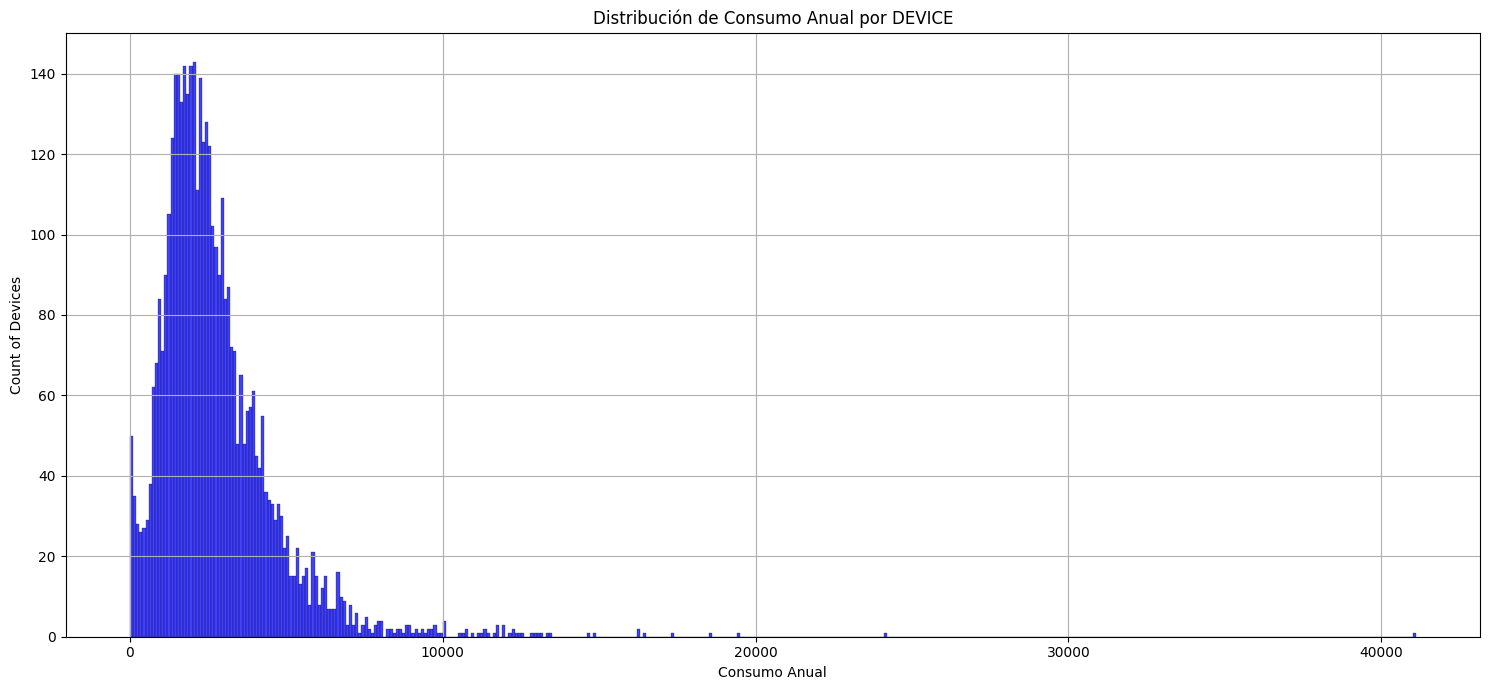

In [302]:
# Distribución de consumo anual por device
consumo_sums = grupo_1_df.groupby('DEVICE')['consumo'].sum().reset_index()

bin_edges = range(0, int(consumo_sums['consumo'].max()) + 100, 100)

plt.figure(figsize=(15, 7))
sns.histplot(consumo_sums['consumo'], bins=bin_edges, kde=False, color='blue')

plt.title('Distribución de Consumo Anual por DEVICE')
plt.xlabel('Consumo Anual')
plt.ylabel('Count of Devices')
plt.grid(True)
plt.tight_layout()

plt.show()

In [303]:
# Creación de dataframe filtrado
consumo_sums = grupo_1_df.groupby('DEVICE')['consumo'].sum().reset_index()
valid_devices = consumo_sums[(consumo_sums['consumo'] >= 700) & (consumo_sums['consumo'] < 8000)]['DEVICE']
grupo_1_df_filt = grupo_1_df[grupo_1_df['DEVICE'].isin(valid_devices)]

Comparación del datasets previo y posterior al filtrado.

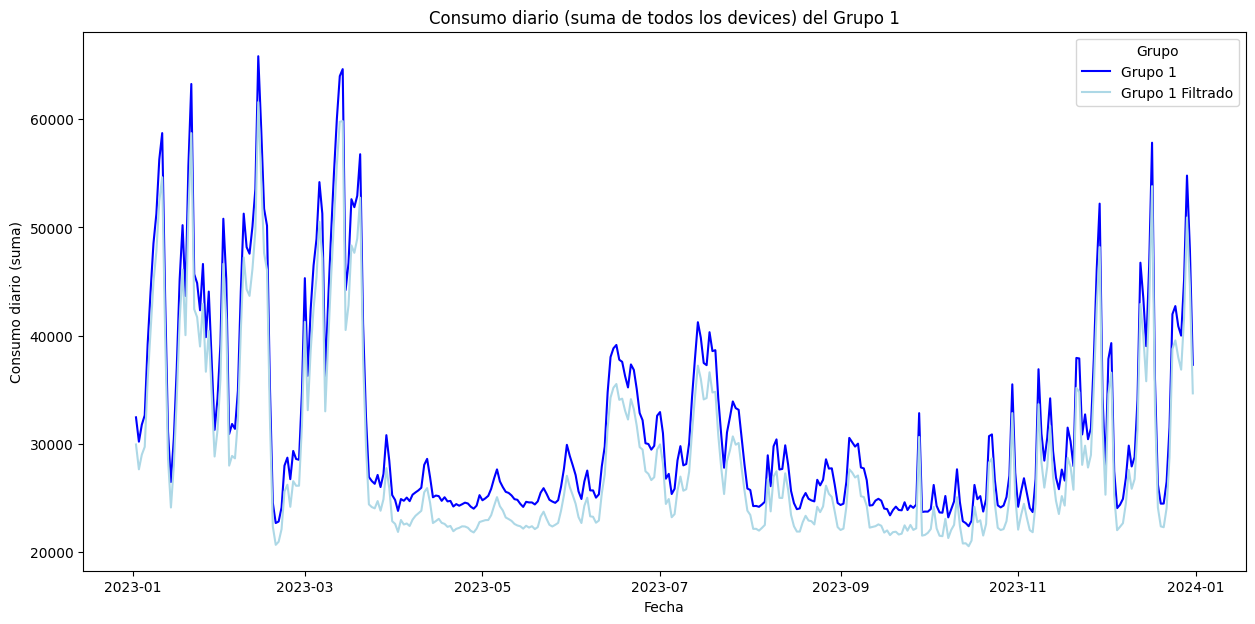

In [304]:
sum_consumo_grupo_1_df = grupo_1_df.groupby('TV')['consumo'].sum().reset_index()
sum_consumo_grupo_1_df['Group'] = 'Grupo 1'

sum_consumo_grupo_1_df_filt = grupo_1_df_filt.groupby('TV')['consumo'].sum().reset_index()
sum_consumo_grupo_1_df_filt['Group'] = 'Grupo 1 Filtrado'

combined_sum_df = pd.concat([sum_consumo_grupo_1_df, sum_consumo_grupo_1_df_filt])
combined_sum_df['TV'] = pd.to_datetime(combined_sum_df['TV'], format='%Y-%m-%d')


plt.figure(figsize=(15, 7))
sns.lineplot(x='TV', y='consumo', hue='Group', data=combined_sum_df, palette={'Grupo 1': 'blue', 'Grupo 1 Filtrado': 'lightblue'})

plt.title('Consumo diario (suma de todos los devices) del Grupo 1')
plt.xlabel('Fecha')
plt.ylabel('Consumo diario (suma)')

plt.legend(title='Grupo')
plt.show()

## Elección del modelo y feature engineering

Mediante el análisis de los datos y la prueba de varios modelos, se llegó a la conclusión de que los datos con los que se disponía representaba una limitante a la hora de los modelos con los que se podía trabajar.

El principal problema es que, al contar sólo con los datos correspondientes a un año calendario, no se está capturando el patrón estacional anual. Por el comportamiento sel consumo observado, difícilmente se pueda predecir el consumo en Noviembre de 2023 si no se cuenta con los datos de Noviembre de 2022, y sólo se cuenta con los datos de Enero a Octubre de 2023. En base a esto se concluyó que se no se puede trabajar con un Modelo Univariado de Series de Tiempo que sólo considere datos de consumo, sino que lo óptimo sería trabajar con un Modelo Multivariado de Series de Tiempo con variables exógenas.

En base a lo observado en los entregables anteriores, se seleccionó como variable exógena la temperatura. No obstante, es posible probar con otras variables exógenas para evaluar otros modelos.

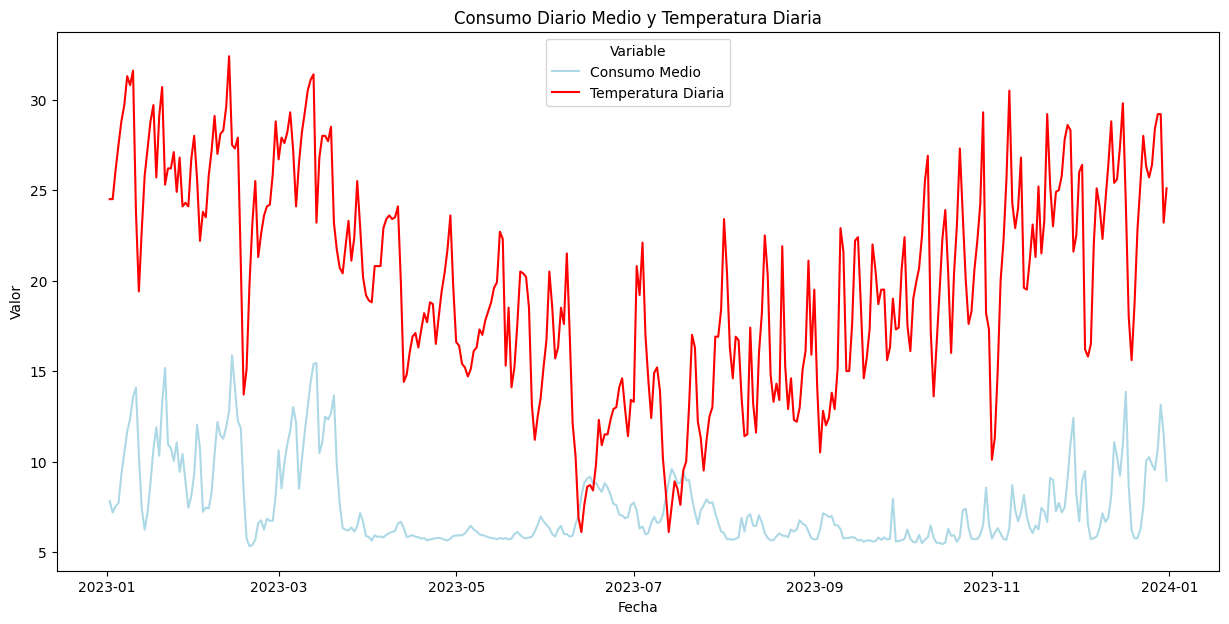

In [305]:
# Gráfico de la media del consumo de cada día y temperatura
mean_consumo = grupo_1_df_filt.groupby('TV')['consumo'].mean().reset_index()
mean_consumo.columns = ['TV', 'consumo_medio']

temperatura_avg = grupo_1_df_filt.groupby('TV')['temperatura_avg'].first().reset_index()

plot_data = mean_consumo.merge(temperatura_avg, on='TV')
plot_data['TV'] = pd.to_datetime(plot_data['TV'], format='%Y-%m-%d')

plt.figure(figsize=(15, 7))

sns.lineplot(x='TV', y='consumo_medio', data=plot_data, color='lightblue', label='Consumo Medio')
sns.lineplot(x='TV', y='temperatura_avg', data=plot_data, color='red', label='Temperatura Diaria')

plt.title('Consumo Diario Medio y Temperatura Diaria')
plt.xlabel('Fecha')
plt.ylabel('Valor')

plt.legend(title='Variable')
plt.show()

En particular, el promedio de la temperatura de un día con los 2 días anteriores, muestra una mayor correlación gráfica con el consumo. Un aspecto central es el hecho de que el comportamiento en relación a la temperatura **se invierte** en el período frío del año (del día 101 al 264 aproximadamente), respecto de los otros días (período cálido) A su vez, el perfil de consumo en el período cálido y el período frío son muy diferentes entre sí, lo que podría ser considerado una pseudoestacionalidad semestral, que el modelo SARIMAX podría reconocer.

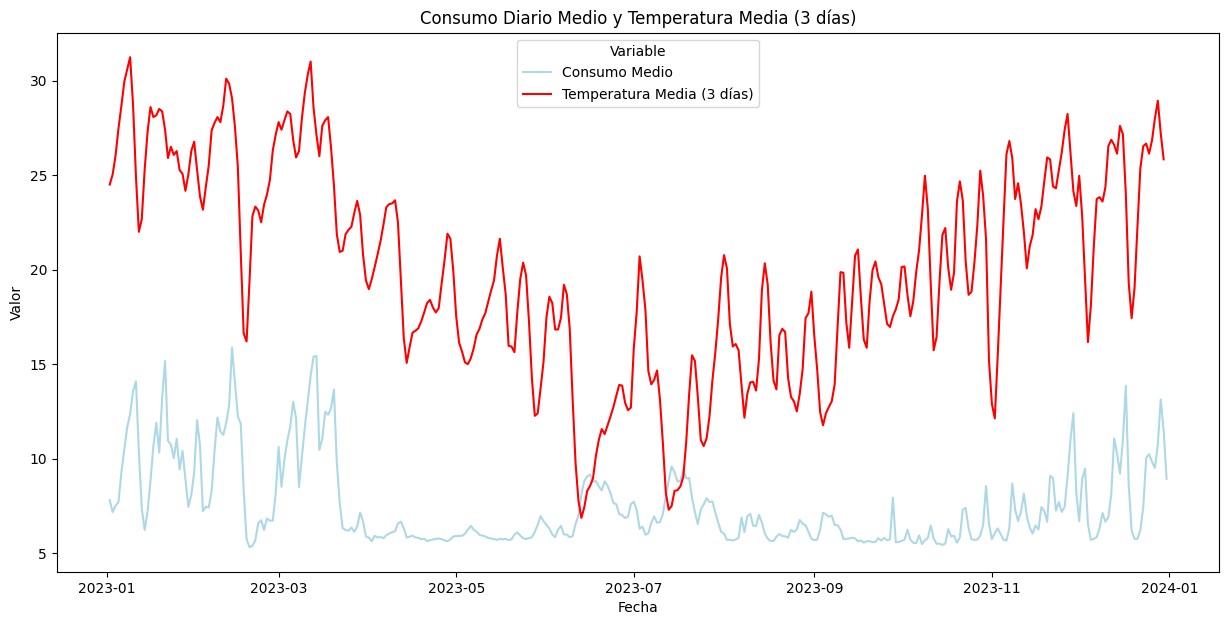

In [306]:
plot_data = mean_consumo.merge(temperatura_avg, on='TV')
plot_data['TV'] = pd.to_datetime(plot_data['TV'], format='%Y-%m-%d')

# Se calcula la media de la temperatura de un día en específico y los 2 días anteriores (Rolling Mean)
plot_data = plot_data.sort_values('TV')
plot_data.set_index('TV', inplace=True)
plot_data['rolling_temp_avg'] = plot_data['temperatura_avg'].rolling(window=3, min_periods=1).mean().shift(-1)

plt.figure(figsize=(15, 7))

sns.lineplot(x=plot_data.index, y=plot_data['consumo_medio'], color='lightblue', label='Consumo Medio')
sns.lineplot(x=plot_data.index, y=plot_data['rolling_temp_avg'], color='red', label='Temperatura Media (3 días)')

plt.title('Consumo Diario Medio y Temperatura Media (3 días)')
plt.xlabel('Fecha')
plt.ylabel('Valor')

plt.legend(title='Variable')
plt.show()

En base a todo esto, se decidió trabajar con un modelo ARIMA estacional con variables exógenas (SARIMAX) usando el promedio de la temperatura media diaria de 3 días como la principal variable exógena. Para proveer información al modelo sobre si se trataba del período frío o del período cálido, se crearon dos términos de interacción capturar el efecto combinado de la temperatura y el período del año. A su vez, se calculó la magnitud del cambio en la temperatura promedio entre días consecutivos, ya que se observó que esto daba cuenta parcialmente de los picos de consumo relacionados a los picos de temperatura. A su vez, debido a que la variable que se intentó predecir es el consumo medio diario, se eliminó la correlación con DEVICE y se dejó una fila por día.

In [307]:
# Aggregate data
df_for_model = grupo_1_df_filt.groupby('TV').agg({
    'consumo': 'mean',
    'consumo_pico': 'mean',
    'consumo_valle': 'mean',
    'consumo_resto': 'mean',
    'temperatura_min': 'first',
    'temperatura_max': 'first',
    'temperatura_avg': 'first'
}).reset_index()

# Convert 'TV' to datetime for further calculations
df_for_model['TV'] = pd.to_datetime(df_for_model['TV'], format='%Y-%m-%d')

# Calculate t_avg_3 (mean of temperatura_avg and the previous two days)
df_for_model.set_index('TV', inplace=True)
df_for_model['t_avg_3'] = df_for_model['temperatura_avg'].rolling(window=3, min_periods=1).mean()

# Reset index to restore 'TV' as a column
df_for_model.reset_index(inplace=True)

# Calculate temperature periods and interaction terms
df_for_model['day_of_year'] = df_for_model['TV'].dt.dayofyear

# Define a function to determine the period
def get_period(day_of_year):
    if day_of_year <= 100 or day_of_year >= 265:
        return 'period_high'
    else:
        return 'period_low'

df_for_model['period'] = df_for_model['day_of_year'].apply(get_period)

# Create interaction terms
df_for_model['temp_period_high'] = df_for_model['temperatura_avg'] * (df_for_model['period'] == 'period_high')
df_for_model['temp_period_low'] = df_for_model['temperatura_avg'] * (df_for_model['period'] == 'period_low')

# Calculate rolling means for interaction terms
df_for_model['temp_period_high_3'] = df_for_model['temp_period_high'].rolling(window=3, min_periods=1).mean()
df_for_model['temp_period_low_3'] = df_for_model['temp_period_low'].rolling(window=3, min_periods=1).mean()

# Step 4: Calculate temperature change magnitude
df_for_model['temp_change_magnitude'] = df_for_model['temperatura_avg'].diff().abs()
df_for_model['temp_change_magnitude'].fillna(0, inplace=True)

In [308]:
df_for_model.head()

,TV,consumo,consumo_pico,consumo_valle,consumo_resto,temperatura_min,temperatura_max,temperatura_avg,t_avg_3,day_of_year,period,temp_period_high,temp_period_low,temp_period_high_3,temp_period_low_3,temp_change_magnitude
0,2023-01-02,7.807649,1.694102,2.092707,4.020840,15.0,32.1,24.5,24.500000,2,period_high,24.5,0.0,24.500000,0.0,0.0
1,2023-01-03,7.176870,1.848364,1.662334,3.666172,18.0,31.5,24.5,24.500000,3,period_high,24.5,0.0,24.500000,0.0,0.0
2,2023-01-04,7.522267,1.746314,1.843900,3.932053,17.5,33.5,26.1,25.033333,4,period_high,26.1,0.0,25.033333,0.0,1.6
3,2023-01-05,7.696574,2.036464,1.777633,3.882477,18.0,35.5,27.5,26.033333,5,period_high,27.5,0.0,26.033333,0.0,1.4
4,2023-01-06,9.281278,2.357150,2.208848,4.715280,19.8,36.7,28.8,27.466667,6,period_high,28.8,0.0,27.466667,0.0,1.3


## Comparación de modelos
Compararemos los modelos Auto Regresivo, ARIMA y SARIMA, sin y convariables exógena.

* Se incluye un AR(0) como referencia. El AR(0) es idéntico utilizando los tres estimadores.

* AutoReg o Autoregressive model: especifica que la variable de salida depende linealmente de sus propios valores anteriores y de un término estocástico (un término imperfectamente predecible).

* ARIMA (AutoRegressive Integrated Moving Average) es una clase de modelos estadísticos que atiende explícitamente la tendencia, la ciclicidad y la autocorrelación en series temporales. El modelo consta de 3 componentes: AR (Autorregresivo): regresión sobre los valores rezagados de la serie temporal, I (Integrado): uso de la diferenciación para hacer que la serie temporal sea estacionaria, MA (Promedio móvil): regresión sobre los errores de pronóstico rezagados.

* SARIMA es una extensión de ARIMA que admite explícitamente la estacionalidad. El modelo agrega tres componentes adicionales a ARIMA: un término AR estacional, un término de diferencia estacional, un término MA estacional

In [309]:
from statsmodels.tsa.api import SARIMAX, AutoReg
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [310]:
final_df_for_model = df_for_model.copy()
final_df_for_model = final_df_for_model.set_index('TV')
# Define split date (the last 30 days)
split_date = final_df_for_model.index[-30]

# Split the data into training and test sets
train = final_df_for_model[final_df_for_model.index < split_date]
test = final_df_for_model[final_df_for_model.index >= split_date]

In [311]:
train_exog = train[['temp_period_high_3']]
test_exog = test[['temp_period_high_3']]

In [312]:
ar0_res = SARIMAX(train['consumo'], order=(0, 0, 0), trend="c").fit()
autoreg_res = AutoReg(train['consumo'], 1, trend="c").fit()
arima_res = ARIMA(train['consumo'], order=(1, 0, 0), trend="c").fit()
sarimax_res = SARIMAX(train['consumo'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 4), trend="c").fit()
autoreg_exog_res = AutoReg(train['consumo'], 1, exog=train_exog, trend="c").fit()
arima_exog_res = ARIMA(train['consumo'], exog=train_exog, order=(1, 0, 0), trend="c").fit()
sarimax_exog_res = SARIMAX(train['consumo'], exog=train_exog, order=(1, 0, 0), seasonal_order=(1, 0, 1, 4), trend="c").fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21387D+00    |proj g|=  2.03952D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   2.040D-06   2.214D+00
  F =   2.2138695360757508     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.8

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75089D+00    |proj g|=  6.94114D-01

At iterate    5    f=  1.47253D+00    |proj g|=  4.08208D-01

At iterate   10    f=  1.37123D+00    |proj g|=  3.95087D-01

At iterate   15    f=  1.36618D+00    |proj g|=  4.92470D-03

At iterate   20    f=  1.36499D+00    |proj g|=  4.20110D-01

At iterate   25    f=  1.35953D+00    |proj g|=  1.58167D-01

At iterate   30    f=  1.35877D+00    |proj g|=  9.73209D-03

At iterate   35    f=  1.35876D+00    |proj g|=  2.00024D-04

At iterate   40    f=  1.35876D+00    |proj g|=  2.64853D-02

At iterate   45    f=  1.35869D+00    |proj g|=  3.96163D-02

At iterate   50    f=  1.35836D+00    |proj g|=  1.76205D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [313]:
# Predicions
predicted_ar0 = ar0_res.predict(start=test.index[0], end=test.index[-1])
predicted_autoreg = autoreg_res.predict(start=test.index[0], end=test.index[-1])
predicted_arima = arima_res.predict(start=test.index[0], end=test.index[-1])
predicted_sarimax = sarimax_res.predict(start=test.index[0], end=test.index[-1])
predicted_autoreg_exog = autoreg_exog_res.predict(start=test.index[0], end=test.index[-1], exog_oos=test_exog)
predicted_arima_exog = arima_exog_res.predict(start=test.index[0], end=test.index[-1], exog=test_exog)
predicted_sarimax_exog = sarimax_exog_res.predict(start=test.index[0], end=test.index[-1], exog=test_exog)

In [314]:
actual = test['consumo']

mae = [
    np.mean(np.abs(predicted_ar0 - actual)),
    np.mean(np.abs(predicted_autoreg - actual)),
    np.mean(np.abs(predicted_arima - actual)),
    np.mean(np.abs(predicted_sarimax - actual)),
    np.mean(np.abs(predicted_autoreg_exog - actual)),
    np.mean(np.abs(predicted_arima_exog - actual)),
    np.mean(np.abs(predicted_sarimax_exog - actual)),
]
rmse = [
    np.sqrt(mean_squared_error(test['consumo'], predicted_ar0)),
    np.sqrt(mean_squared_error(test['consumo'], predicted_autoreg)),
    np.sqrt(mean_squared_error(test['consumo'], predicted_arima)),
    np.sqrt(mean_squared_error(test['consumo'], predicted_sarimax)),
    np.sqrt(mean_squared_error(test['consumo'], predicted_autoreg_exog)),
    np.sqrt(mean_squared_error(test['consumo'], predicted_arima_exog)),
    np.sqrt(mean_squared_error(test['consumo'], predicted_sarimax_exog)),
] 

llf = [
    ar0_res.llf,
    autoreg_res.llf,
    arima_res.llf,
    sarimax_res.llf,
    autoreg_exog_res.llf,
    arima_exog_res.llf,
    sarimax_exog_res.llf,
]

aic = [
    ar0_res.aic,
    autoreg_res.aic,
    arima_res.aic,
    sarimax_res.aic,
    autoreg_exog_res.aic,
    arima_exog_res.aic,
    sarimax_exog_res.aic,
]

cols = ["AR(0)", "AutoReg", "ARIMA", "SARIMAX", "AutoReg c/Exogena", "ARIMA c/Exogena",  "SARIMAX c/Exogena"]
pd.DataFrame(
    [mae, rmse, llf, aic],
    columns=cols,
    index=["mae", "rmse", "Log Likelihood", "AIC"],
)

,AR(0),AutoReg,ARIMA,SARIMAX,AutoReg c/Exogena,ARIMA c/Exogena,SARIMAX c/Exogena
mae,2.088052,2.079508,2.071933,2.069379,1.768300,1.471258,1.448308
rmse,2.552704,2.609362,2.595877,2.591445,2.060136,1.762952,1.747808
Log Likelihood,-739.432425,-469.824985,-471.552841,-471.548691,-462.938994,-453.942905,-453.693468
AIC,1482.864850,945.649969,949.105681,953.097382,933.877988,915.885810,919.386936


Conclusiones:
* RMSE mide la desviación estándar de los errores. MAE indica el error absoluto de los valores reales. Juntos cuantifican el rendimiento predictivo de los datos nuevos.
* Debemos elegir un modelo con el valor RMSE y MAE más bajo en los datos de prueba. Esto da como resultado los pronósticos más precisos con menos errores.
* Log Likelihood: mide qué tan bien el modelo se ajusta a los datos y qué tan bien los parámetros explican los datos observados. Cuanto mayor sea el valor, mejor será el modelo.
* AIC: Al seleccionar un modelo, intentamos minimizar el error. Pero no basta con utilizar el error como criterio de selección del modelo porque, a medida que aumentamos el número de parámetros, el error disminuye, pero se sobreajusta y el modelo no funcionará bien con datos fuera de la muestra. AIC también tiene en cuenta el número de parámetros y penaliza el uso de parámetros adicionales. Es muy útil en el modelado de series temporales porque en series temporales es muy fácil aumentar el desfase para reducir el error y obtener un mejor ajuste, pero tiende a sobreajustarse. Cuanto menor sea su valor, mejor será el modelo (consideramos su valor real y no el valor absoluto para la comparación).
* Los modelos que incluyeron variables exógenas tienen más precisión que el mismo modelo sin variable.
* Entre ellos el modelo SARIMAX parece brindar mejores resultados.

## Entrenamiento, Optimización y Evaluación del Modelo SARIMAX

In [315]:
final_df_for_model = df_for_model.copy()

In [316]:
# Se establece la columna 'TV' como índice
final_df_for_model = final_df_for_model.set_index('TV')

Entrenamiento del modelo

El dataset se particionó en train y test en una relación aproximadamente de 90:10 (364 y 30 días respectivamente). Los parámetros p, d, q y P, D, Q, s se seleccionaron conforme a la prueba manual de aquellas combinaciones que resultaban en una mejor predicción.

In [317]:
from itertools import product

In [318]:
ps = range(0, 2)
qs = range(3, 6)

p = 0
d = 1 
q = 4

Ps = range(0, 2)
Qs = range(0, 3)

P = 0
D = 1 
Q = 1
s = 4

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


36

In [319]:
train_exog = train[['temp_period_high_3', 'temp_change_magnitude']]
test_exog = train[['temp_period_high_3', 'temp_change_magnitude']]

In [320]:
series = train['consumo']

In [321]:
# gs_ por Grid Search para el modelo SARIMAX
# Documentación sobre los diferentes metodos de optimización: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.fit.html
def gs_arima(series, parameters_list, d, D, s, opt_method='powell'):
    """
        Return dataframe with parameters and corresponding AIC, and the best model according to AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    models = {}
    best_aic = float("inf")

    for param in parameters_list:
        # we need try-except because on some combinations model might fail to converge
        try:
            model = SARIMAX(
                series, 
                order=(param[0], d, param[1]), 
                seasonal_order=(param[2], D, param[3], s),
                exog=train_exog
                ).fit(method=opt_method, disp=False)
        except:
            continue

        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table, best_model


In [322]:
result_table, best_model = gs_arima(series, parameters_list, d, D, s)


In [323]:
# A menor AIC mejor modelo
result_table.head(10).sort_values(by='aic', ascending=True)


,parameters,aic
0,"(1, 3, 0, 1)",894.967887
1,"(0, 3, 0, 2)",895.389332
2,"(0, 3, 1, 1)",897.077776
3,"(1, 3, 0, 2)",897.401119
4,"(1, 3, 1, 1)",898.912560
5,"(0, 4, 1, 0)",902.886391
6,"(0, 3, 1, 2)",903.119816
7,"(0, 5, 1, 0)",903.139973
8,"(0, 3, 0, 1)",904.078252
9,"(1, 4, 1, 0)",904.154872


In [324]:
best_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             consumo   No. Observations:                  334
Model:             SARIMAX(1, 1, 3)x(0, 1, [1], 4)   Log Likelihood                -439.484
Date:                             Tue, 24 Sep 2024   AIC                            894.968
Time:                                     23:26:35   BIC                            925.336
Sample:                                 01-02-2023   HQIC                           907.083
                                      - 12-01-2023                                         
Covariance Type:                               opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
temp_period_high_3        0.1674      0.028      5.893      0.000       0.112       0.223
temp_change_magnitude     0.1079      0.020      5.325      0.000       0.068       0.148
ar.L1                     0.7927      0.085      9.360      0.000       0.627       0.959
ma.L1                    -0.7571      0.096     -7.916      0.000      -0.945      -0.570
ma.L2                    -0.2197      0.057     -3.854      0.000      -0.331      -0.108
ma.L3                     0.0349      0.059      0.592      0.554      -0.081       0.150
ma.S.L4                  -0.9995      1.148     -0.870      0.384      -3.250       1.251
sigma2                    0.7957      0.908      0.877      0.381      -0.983       2.575
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                98.89
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Evaluación del modelo

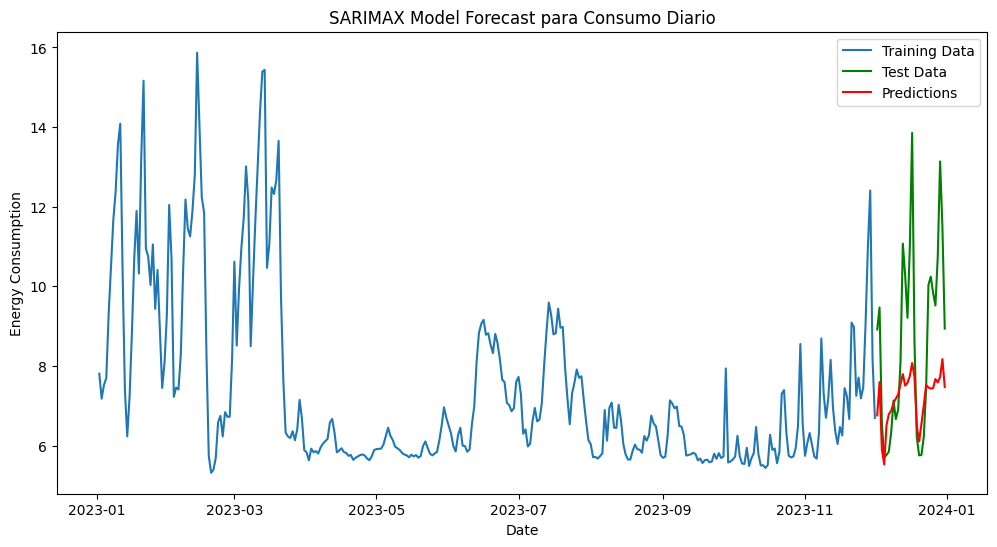

Mean Absolute Error (MAE): 1.7147717690334336
Root Mean Squared Error (RMSE): 2.2689963094844634
Log Likelihood: -439.48394369959146
AIC: 894.9678873991829


In [326]:
# Generate predictions on the test set
test_exog = test[['temp_period_high_3', 'temp_change_magnitude']]
predictions = best_model.predict(start=test.index[0], end=test.index[-1], exog=test_exog)

# Evaluate the model
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['consumo'], label='Training Data')
plt.plot(test.index, test['consumo'], label='Test Data', color='green')
plt.plot(test.index, predictions, label='Predictions', color='red')
plt.legend()
plt.title('SARIMAX Model Forecast para Consumo Diario')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.show()

# Optionally calculate metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), etc.
mae = np.mean(np.abs(predictions - test['consumo']))
rmse = np.sqrt(mean_squared_error(test['consumo'], predictions))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Log Likelihood: {best_model.llf}')
print(f'AIC: {best_model.aic}')

De acuerdo a los errores calculados, el valor de consumo predicho se aleja aproximadamente un promedio de 1-2 unidades del valor real (de acuerdo a las magnitudes del consumo, esto representa un error de aproximadamente el 15%). Sin embargo, el gráfico permite identificar que cuanto más agudos son los picos del consumo, peor es la predicción. Esto indica que se debe añadir alguna modificación al modelo que de cuenta de estos cambios abruptos en el consumo para no sub-estimar el consumo en estas circunstancias.

En general, consideramos que este modelo es aceptable para predecir el consumo medio del grupo 1. Las perspectivas a futuro incluyen probar este mismo modelo en datos de devices individuales, y probar nuevas variables exógenas que permitan ajustar la estimación.

## Bandas de Consumo Eléctrico y un nuevo modelo que agregue sus predicciones

Sería interesante optimizar un modelo para cada banda de consumo eléctrico, dado que cada banda podría comportarse en forma diferente al tener **diferente tarifa**, estar sometida a diferentes **condiciones ambientales** (temperatura,..), y enfrentar **diferente demanda** (horarios laborales..). 

In [327]:
# Partimos de los mismos datos (grupo tarifario 1 y ya filtrados) utilizados anteriormente. 
# Solo pretendemos corrobar la hipótesis de que podría obtenerse un mejor modelo agregnado las predicciones por banda y compararlo con el anterior
grupo_1_df_filt.head()

,DEVICE,TV,consumo,consumo_pico,consumo_valle,consumo_resto,temperatura_min,temperatura_max,temperatura_avg
0,0.0,2023-01-02,4.508,1.064,1.521,1.923,15.0,32.1,24.5
1,0.0,2023-01-03,3.803,0.906,1.000,1.897,18.0,31.5,24.5
2,0.0,2023-01-04,3.837,0.922,0.908,2.007,17.5,33.5,26.1
3,0.0,2023-01-05,3.648,0.852,0.957,1.839,18.0,35.5,27.5
4,0.0,2023-01-06,4.218,0.938,1.038,2.242,19.8,36.7,28.8


Pero observamos que los datos metereologicos corresponde a valores medios del día, no tenemos datos por franja de consumo eléctrico. Estos datos fueron obtenidos por hora y luego promediados por franja en el notebook *Meteorologia_SMN.ipynb* cargaremos el dataset *meteorologia_cordoba.csv*

In [328]:
# Cargar previamente modelo_epec.csv en la sesión de Google Colab
meterologia = pd.read_csv('meteorologia_cordoba.csv', sep=';')

In [329]:
with pd.option_context('display.max_columns', None):
    print(meterologia.head())

        fecha  temperatura    humedad  presion_atm          dd    viento  \
0  2023-01-01    21.266667  87.000000  1009.083333  210.000000  7.333333   
1  2023-01-02    18.566667  69.166667  1013.250000  255.000000  4.666667   
2  2023-01-03    21.183333  58.333333  1008.316667  288.333333  4.333333   
3  2023-01-04    20.650000  78.333333  1012.633333  188.333333  6.333333   
4  2023-01-05    23.550000  42.166667  1011.366667  236.666667  4.000000   

   sensacion_termica  banda  
0          21.266667  valle  
1          18.566667  valle  
2          21.183333  valle  
3          20.650000  valle  
4          23.550000  valle  


In [330]:
# Crearemos tres datasets para hacer la predicción utilizando las variables exógenas adecuadas para cada banda
# Definimos las franjas de consumo y datos
bandas = ['pico', 'valle', 'resto']
columnas_consumo = ['consumo_pico', 'consumo_valle', 'consumo_resto']

filtered_dfs = {}

for banda, columna_consumo in zip(bandas, columnas_consumo):
    # Filtrado de los datos principales
    filtered_dfs[banda] = grupo_1_df_filt[['DEVICE', 'TV', columna_consumo]]
    
    # Filtrado de los datos meteorologicos para cada banda
    meteo_banda = meterologia.loc[meterologia['banda'] == banda][['fecha', 'sensacion_termica', 'temperatura', 'humedad', 'presion_atm', 'viento']]
    
    # Combinamos el consumo por banda con los datos metereologicos observados
    filtered_dfs[banda] = pd.merge(filtered_dfs[banda], meteo_banda, left_on='TV', right_on='fecha')
    
    # Podriamos renombrar el consumo_[banda] por la palabra consumo para simplificar
    filtered_dfs[banda].rename(columns={columna_consumo: 'consumo'}, inplace=True)
    
    # Drop la columna redundante
    filtered_dfs[banda].drop(columns=['fecha'], inplace=True)
    
    # Agruparemos los datos
    filtered_dfs[banda] = filtered_dfs[banda].groupby('TV').agg({
        'consumo': 'mean',
        'sensacion_termica': 'first',
        'temperatura': 'first',
        'humedad': 'first',
        'presion_atm': 'first', 
        'viento': 'first'
    }).reset_index()
        
# DataFrames con los consumos por bandas y variables exogenas
df_for_model_pico = filtered_dfs['pico']
df_for_model_valle = filtered_dfs['valle']
df_for_model_resto = filtered_dfs['resto']

In [331]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [332]:
dataframes = [df_for_model_pico, df_for_model_valle, df_for_model_resto]

# Convertimos 'TV' a datetime para cada uno
for df in dataframes:
    df['TV'] = pd.to_datetime(df['TV'], format='%Y-%m-%d')
    
    # Calculate t_avg_3 (mean of temperatura_avg and the previous two days)
    df.set_index('TV', inplace=True)
    df['t_avg_3'] = df['sensacion_termica'].rolling(window=3, min_periods=1).mean()

    # Reset index to restore 'TV' as a column
    df.reset_index(inplace=True)

    # Calculate temperature periods and interaction terms
    df['day_of_year'] = df['TV'].dt.dayofyear

    # Define a function to determine the period
    def get_period(day_of_year):
        if day_of_year <= 100 or day_of_year >= 265:
            return 'period_high'
        else:
            return 'period_low'

    df['period'] = df['day_of_year'].apply(get_period)

    # Create interaction terms
    df['temp_period_high'] = df['sensacion_termica'] * (df['period'] == 'period_high')
    df['temp_period_low'] = df['sensacion_termica'] * (df['period'] == 'period_low')

    # Calculate rolling means for interaction terms
    df['temp_period_high_3'] = df['temp_period_high'].rolling(window=3, min_periods=1).mean()
    df['temp_period_low_3'] = df['temp_period_low'].rolling(window=3, min_periods=1).mean()

    # Step 4: Calculate temperature change magnitude
    df['temp_change_magnitude'] = df['sensacion_termica'].diff().abs()
    df['temp_change_magnitude'].fillna(0, inplace=True)

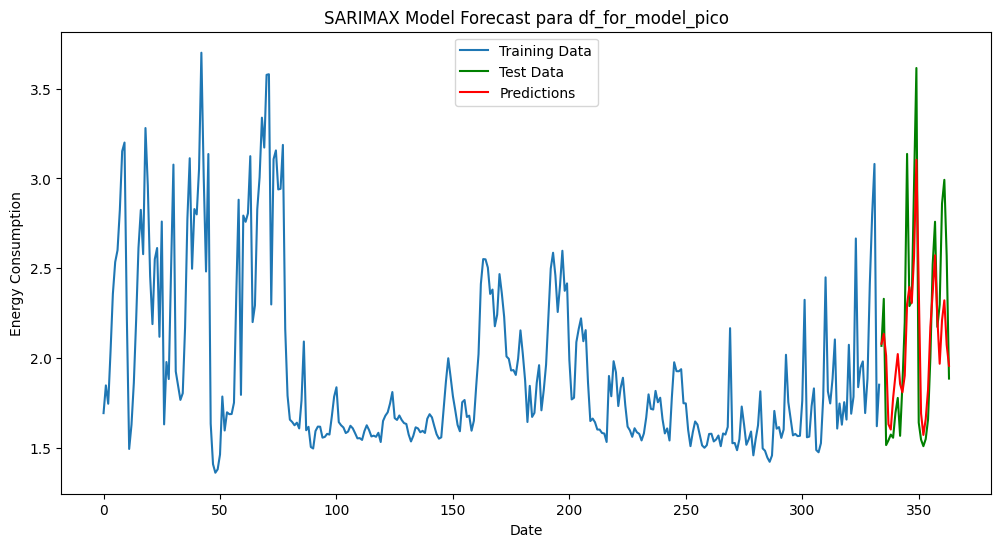

Mean Absolute Error (MAE) df_for_model_pico: 0.2669219313451139
Root Mean Squared Error (RMSE) df_for_model_pico: 0.35158170980946346
Log Likelihood df_for_model_pico: -24.10974130339312
AIC df_for_model_pico: 66.21948260678624


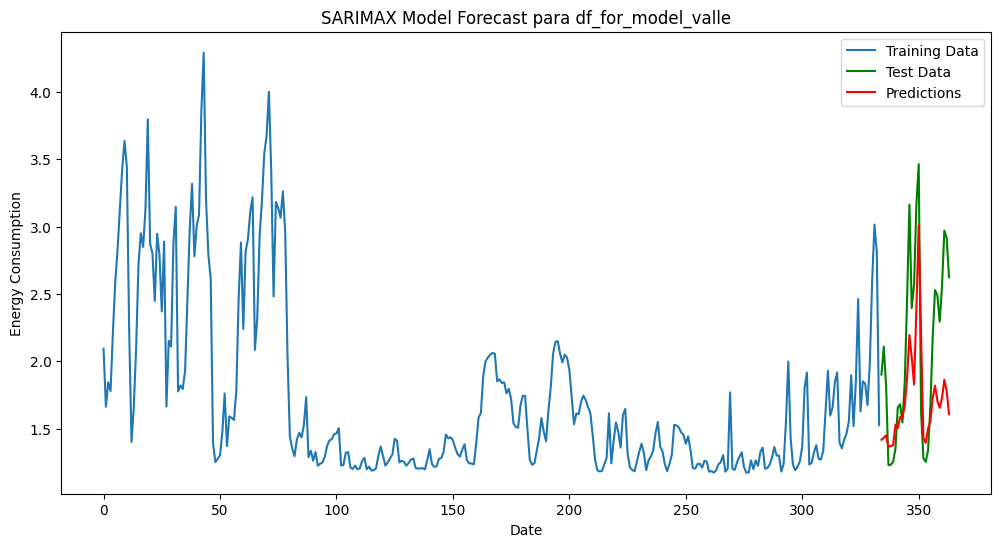

Mean Absolute Error (MAE) df_for_model_valle: 0.475851666720992
Root Mean Squared Error (RMSE) df_for_model_valle: 0.5813474393736269
Log Likelihood df_for_model_valle: 4.495155535332671
AIC df_for_model_valle: 13.009688929334658


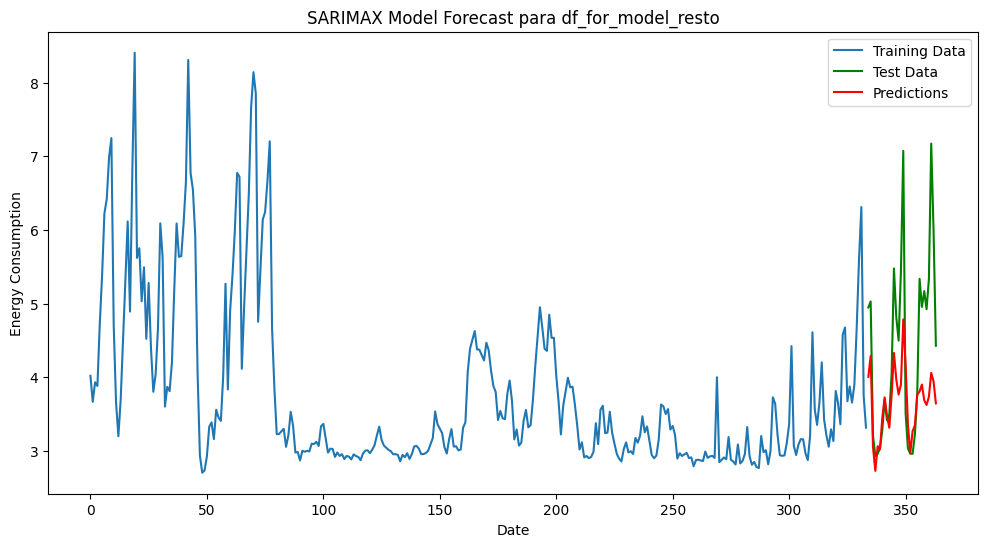

Mean Absolute Error (MAE) df_for_model_resto: 0.7927578267157459
Root Mean Squared Error (RMSE) df_for_model_resto: 1.1093067492524598
Log Likelihood df_for_model_resto: -247.69172442923764
AIC df_for_model_resto: 517.3834488584753


In [333]:
for df in dataframes:
    nombre = get_df_name(df)
    final_df_for_model = df.copy()
    
    # Definimos la fecha de separación (los últimos 30 días)
    split_date = final_df_for_model.index[-30]

    # Separamos los datos en train y test
    train = final_df_for_model[final_df_for_model.index < split_date]
    test = final_df_for_model[final_df_for_model.index >= split_date]
    
    # Elegimos la o las variables exógenas
    train_exog = train[['sensacion_termica','temp_period_high_3', 'temp_change_magnitude']]
    test_exog = test[['sensacion_termica','temp_period_high_3', 'temp_change_magnitude']]
    
    # la serie de datos
    series = train['consumo']
    
    # evaluamos los modelos
    result_table_banda, best_model_banda = gs_arima(series, parameters_list, d, D, s)
    
    # Los enumeramos, a menor AIC mejor modelo
    result_table_banda.head(10).sort_values(by='aic', ascending=True)
    
    # nos quedamos con el mejor
    best_model_banda.summary()
    
    # Generate predictions on the test set
    predictions = best_model_banda.predict(start=test.index[0], end=test.index[-1], exog=test_exog)

    # Visualizamos el modelo
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['consumo'], label='Training Data')
    plt.plot(test.index, test['consumo'], label='Test Data', color='green')
    plt.plot(test.index, predictions, label='Predictions', color='red')
    plt.legend()
    plt.title(f'SARIMAX Model Forecast para {nombre}')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption')
    plt.show()

    # Evaluamos las métricas Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), etc.
    mae = np.mean(np.abs(predictions - test['consumo']))
    rmse = np.sqrt(mean_squared_error(test['consumo'], predictions))

    print(f'Mean Absolute Error (MAE) {nombre}: {mae}')
    print(f'Root Mean Squared Error (RMSE) {nombre}: {rmse}')
    print(f'Log Likelihood {nombre}: {best_model_banda.llf}')
    print(f'AIC {nombre}: {best_model_banda.aic}')
    

## Conclusiones

El modelo es aceptable para una estimación general del consumo. La mejora sustancial de este modelo se daría de contar con datos de un período mayor de tiempo, al menos 1 o 2 años calendario más. En este caso, la variable de temperatura diaria es buena para predecir el consumo. La predicción se pudo mejorar añadiendo información acerca de los períodos "frío" y "cálido". Es posible que la adición de otras variables exógenas permitan predecir con mayor precisión el comportamiento de los picos de consumo.

Se verifica que el modelo por banda de consumo da mejores predicciones que el modelo diario.